## Spectrogram Analysis using VGG

In [30]:
## What we can conclude from this file is that VGG is not suitable for usic style transfer as the conv filters are 3x3 which is not suitable for a 1D Signal(Music)

import tensorflow as tf
import numpy as np
import skimage
import os
from skimage import io
import scipy.io.wavfile
from tensorflow.keras.applications.vgg19 import VGG19
from keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Libraries

In [31]:
!pip install librosa --upgrade
!pip install pydub
!apt-get install ffmpeg
!pip install pygobject

Requirement already up-to-date: librosa in /usr/local/lib/python3.6/dist-packages (0.8.0)
Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.


## Fetch music files

In [32]:
import librosa
import cv2
import scipy
import librosa.display

## LoadMusic Files
def loadMusic(path , songNumber):
  x, sr = librosa.load(path, sr=44100)
  X = librosa.stft(x)
  spectrogram_librosa_db = librosa.power_to_db(X, ref=np.max)
  librosa.display.specshow(spectrogram_librosa_db, sr=sr, y_axis='log', x_axis='time')
  plt.title('Reference power spectrogram')
  plt.colorbar(format='%+2.0f dB')
  plt.tight_layout()
  plt.show()
  val = librosa.griffinlim(X)  ## Change to griffin lim as the phase information is retained
  maxVal = val.max()
  val = val / maxVal;
  #val = np.rint(val).astype(np.int16)
  scipy.io.wavfile.write('/content/song' + str(songNumber) + '.wav',44100,val)

## X is the music file downloaded from drive  
  X = [spectrogram_librosa_db , spectrogram_librosa_db , spectrogram_librosa_db]
  X = np.array(X)
  return np.reshape(X , (X.shape[1] , X.shape[2] , 3))

In [33]:
## Checking Sampling Rate of the music Files.

## Connect with drive.
from google.colab import drive
drive.mount('/content/drive')

from pydub.utils import mediainfo
info = mediainfo("/content/drive/My Drive/Nokia/mp3 data/data/wonderwall.mp3")
print("Content Music Sampling Rate : " + str(info['sample_rate']))
info = mediainfo("/content/drive/My Drive/Nokia/mp3 data/data/gettysburg.mp3")
print("Style Music Sampling Rate : " + str(info['sample_rate']))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Content Music Sampling Rate : 44100
Style Music Sampling Rate : 44100


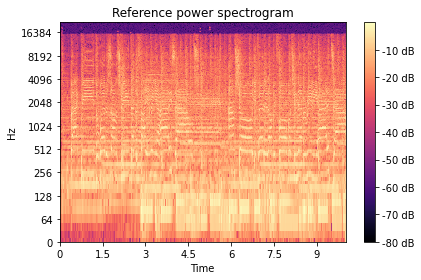

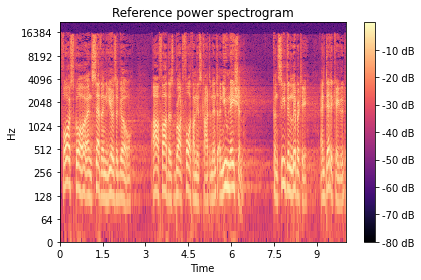

In [34]:
## Load Style and Content Music
styleMusic = loadMusic("/content/drive/My Drive/Nokia/mp3 data/data/wonderwall.mp3",1)
contentMusic = loadMusic("/content/drive/My Drive/Nokia/mp3 data/data/gettysburg.mp3",2)

## Spectrogram Image Display Functions

In [35]:
def get_image(X):
    w=512
    h=512
   
    image = tf.keras.applications.vgg19.preprocess_input(tf.keras.preprocessing.image.img_to_array(X))
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = np.expand_dims(image , axis = 0)
    return image
def imgshow(image):
    image[:,:,0]  *=64/255.0
    image[:,:,1] *=128/255.0
    image[:,:,2] *=192/255.0
    image = image[:,:,::-1]
    image = np.clip(image,0,255).astype('uint8')
    img=np.squeeze(image)
    plt.figure(figsize = (50,10))
    plt.imshow(img, interpolation='nearest')
def imshowImage(image):
  image[:,:,0]  *=64/255.0
  image[:,:,1] *=128/255.0
  image[:,:,2] *=192/255.0
  image = image[:,:,::-1]
  image = np.clip(image,0,255).astype('uint8')
  img=np.squeeze(image)
  return img
#styleImage = get_image("/content/style.jpg")
#contentImage = get_image("/content/content.jpg")
#imgshow(styleImage)

styleMusicImage = get_image(styleMusic);
contentMusicImage = get_image(contentMusic);

## Gram Matrix

In [36]:
def gramMatrix(inputImage):
  channels=int(inputImage.shape[-1])
  a=tf.reshape(inputImage,[-1,channels])
  n=tf.shape(a)[0]
  gram=tf.matmul(a,a,transpose_a=True)
  return(gram/tf.cast(n,tf.float32))

## Style Loss

In [37]:
def styleLoss(model,inputImage,generated):
  error = 0
  for styleModels in model:
    styleVal = styleModels(inputImage);
    generatedVal = styleModels(generated)
    val = tf.reduce_mean((gramMatrix(styleVal) - gramMatrix(generatedVal))**2);
    error = error + val*1/len(model);
  return error;

## VGG-19

In [38]:
baseModel = VGG19(weights='imagenet',include_top=False,pooling='Max');
baseModel.trainable = False;
contentImageLayers = ['block5_conv2']
styleImageLayers = ["block1_conv1","block2_conv1","block3_conv1","block4_conv1","block5_conv1"]
baseModel.get_layer(contentImageLayers[0])
print(baseModel.input)

KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


## Content Feature Extraction Model

In [39]:
contentModel = Model(inputs = baseModel.input,outputs = baseModel.get_layer(contentImageLayers[0]).output) 

## Style Feature Extraction Model

In [40]:
styleModel = [Model(inputs = baseModel.input , outputs = baseModel.get_layer(Layer).output) for Layer in styleImageLayers]

In [41]:
def customLoss(model,inputImage,outputImage):
  val = tf.reduce_mean((model(inputImage) - model(outputImage))**2)
  return val;

## RunFuction

In [42]:
def runFunction(contentImage,styleImage):
  ## Calculate loss for content image
  ## Calculate loss for style image
  ## update the initial image by the error from the losses calculated
  ## repeat the process
  contentGenerated = tf.Variable(contentImage,dtype = tf.float32);
  print(contentGenerated.shape)
  optimizer = tf.keras.optimizers.Adam(learning_rate = 1)
  maxImage = contentGenerated;
  maxCost = 1e12

  ## Weighted Loss calcualtion
  for i in range(0,10):  ####    Train till 500 steps
    print('Iteration : ' + str(i))
    with tf.GradientTape() as tape:
      print(contentGenerated.shape)
      contentLossVal = customLoss(contentModel,contentImage,contentGenerated)
      styleLossVal = styleLoss(styleModel , styleImage , contentGenerated)
      cost = contentLossVal * 40 + styleLossVal * 1000;
      gradient = tape.gradient(cost , contentGenerated);
      optimizer.apply_gradients([(gradient,contentGenerated)])
      print(cost)
      if(cost < maxCost):
        maxCost = cost;
        musicImage = contentGenerated.numpy();
  X  = (musicImage[: , : , :, 0] + musicImage[: , : , : , 1] + musicImage[: , : , : ,2]) / 3;
  X = np.reshape(X , (X.shape[1] , X.shape[2]))
  val = librosa.griffinlim(X)  ## Change to griffin lim as the phase information is retained
  val = np.rint(val).astype(np.int16)
  print(val.min())
  print(val.max())
  val = val / val.max()
  scipy.io.wavfile.write('/content/songOutput.wav',44100,val)
  return musicImage,contentGenerated.numpy();

In [43]:
runFunction(contentMusicImage , styleMusicImage)  ## musicImage , imgVal = runFunction(contentMusicImage , styleMusicImage)

(1, 1025, 862, 3)
Iteration : 0
(1, 1025, 862, 3)
tf.Tensor(2432896300000.0, shape=(), dtype=float32)
Iteration : 1
(1, 1025, 862, 3)
tf.Tensor(1048795100000.0, shape=(), dtype=float32)
Iteration : 2
(1, 1025, 862, 3)
tf.Tensor(623097300000.0, shape=(), dtype=float32)
Iteration : 3
(1, 1025, 862, 3)
tf.Tensor(519835980000.0, shape=(), dtype=float32)
Iteration : 4
(1, 1025, 862, 3)
tf.Tensor(435034700000.0, shape=(), dtype=float32)
Iteration : 5
(1, 1025, 862, 3)
tf.Tensor(346232260000.0, shape=(), dtype=float32)
Iteration : 6
(1, 1025, 862, 3)
tf.Tensor(319640080000.0, shape=(), dtype=float32)
Iteration : 7
(1, 1025, 862, 3)
tf.Tensor(262288740000.0, shape=(), dtype=float32)
Iteration : 8
(1, 1025, 862, 3)
tf.Tensor(215035800000.0, shape=(), dtype=float32)
Iteration : 9
(1, 1025, 862, 3)
tf.Tensor(192711590000.0, shape=(), dtype=float32)
-25
27


(array([[[[-158.00645 , -150.64447 , -148.95564 ],
          [-156.90916 , -138.95497 , -127.96629 ],
          [-155.07196 , -140.14029 , -138.23221 ],
          ...,
          [-154.13469 , -141.73102 , -129.9654  ],
          [-153.75398 , -141.41849 , -132.8703  ],
          [-161.15987 , -156.36981 , -136.98143 ]],
 
         [[-150.77266 , -139.2603  , -132.17609 ],
          [-158.35487 , -150.23099 , -132.52505 ],
          [-150.36728 , -142.10051 , -126.91403 ],
          ...,
          [-138.65625 , -123.049545, -116.800705],
          [-141.04593 , -131.10028 , -116.569954],
          [-150.20071 , -134.39925 , -121.826775]],
 
         [[-155.08661 , -145.90602 , -133.60161 ],
          [-152.45016 , -141.99805 , -129.06532 ],
          [-162.07727 , -144.0616  , -130.43257 ],
          ...,
          [-145.4676  , -137.18895 , -121.40343 ],
          [-142.01367 , -129.41939 , -113.62529 ],
          [-143.34558 , -130.74554 , -117.668846]],
 
         ...,
 
         [[-

## Ignore Code Below this line

In [18]:
X  = (musicImage[: , : , :, 0] + musicImage[: , : , : , 1] + musicImage[: , : , : ,2]) / 3;

In [19]:
X = np.reshape(X , (X.shape[1] , X.shape[2]))

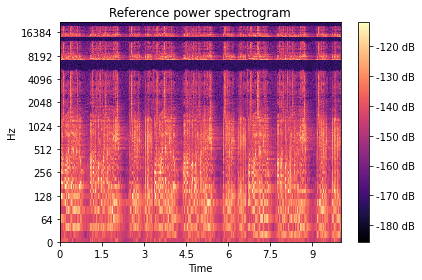

In [20]:
librosa.display.specshow(X, sr=44100, y_axis='log', x_axis='time')
plt.title('Reference power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

In [21]:
val = librosa.griffinlim(X)  ## Change to griffin lim as the phase information is retained
val = np.rint(val).astype(np.int16)
print(val.min())
print(val.max())
val = val / val.max()
scipy.io.wavfile.write('/content/songOutput.wav',44100,val)

-26
26
